In [1]:
import osmnx as ox
import pandas as pd
import geopandas as gpd
import networkx as nx
import numpy as np
import multiprocessing as mp
import random as rd
from itertools import product
from descartes import PolygonPatch
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from IPython.display import clear_output
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.ticker as mtick
from pylab import MaxNLocator
from shapely.wkt import loads as load_wkt
import warnings
warnings.filterwarnings('ignore')

ox.config(log_console=True, use_cache=True, cache_folder = '/home/diogo_mota/Dropbox/Diogo_Rede_simetria/Beta_Experiment/Network_Data') 
ox.__version__

'0.16.2'

# Loading and Preparing Data:

In [2]:
## Get the data from OpenStreetMaps
cities = ox.geocode_to_gdf(['Município de Lisboa'])['geometry'].iloc[0]

G_lx = ox.graph_from_polygon(cities, network_type='drive', simplify=True)
nodes, edges = ox.graph_to_gdfs(G_lx, nodes=True, edges=True)

In [3]:
## Get all amenities that OpenStreetMaps has in Lisbon
hospitals = ox.pois_from_place('Município de Lisboa', tags = {'amenity': True})

In [4]:
## Filter the amenities to get only the hospitals
hospitals[hospitals.amenity=='hospital']

/home/diogo_mota/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


unique_id       osmid element_type   amenity  \
2127    node/3810108484  3810108484         node  hospital   
2989    node/4693698451  4693698451         node  hospital   
3277    node/4788095254  4788095254         node  hospital   
3279    node/4788769526  4788769526         node  hospital   
5870    node/8108472292  8108472292         node  hospital   
5877    node/8108472301  8108472301         node  hospital   
6566       way/54664695    54664695          way  hospital   
6577       way/71507621    71507621          way  hospital   
6578       way/71570486    71570486          way  hospital   
6580       way/71571984    71571984          way  hospital   
6661       way/97821504    97821504          way  hospital   
6664       way/97822055    97822055          way  hospital   
6671       way/98115214    98115214          way  hospital   
6724      way/101506697   101506697          way  hospital   
6749      way/115235575   115235575          way  hospital   
6779      way/138258185   138258185          way  hospital   
6851      way/155331041   155331041          way  hospital   
6938      way/183414003   183414003          way  hospital   
7175      way/240200175   240200175          way  hospital   
7203      way/242346630   242346630          way  hospital   
7211      way/242715872   242715872          way  hospital   
7244      way/245072839   245072839          way  hospital   
7307      way/304644256   304644256          way  hospital   
7333      way/337051098   337051098          way  hospital   
7356      way/363205302   363205302          way  hospital   
7382      way/383387707   383387707          way  hospital   
7474      way/426369212   426369212          way  hospital   
7572      way/486192612   486192612          way  hospital   
7674      way/536213383   536213383          way  hospital   
7913      way/661314822   661314822          way  hospital   
8328      way/940457865   940457865          way  hospital   
8377   relation/6551427     6551427     relation  hospital   
8426  relation/12683372    12683372     relation  hospital   

                                               geometry created_by barrier  \
2127                          POINT (-9.17486 38.75669)        NaN     NaN   
2989                          POINT (-9.15370 38.71665)        NaN     NaN   
3277                          POINT (-9.17573 38.75672)        NaN     NaN   
3279                          POINT (-9.14609 38.75711)        NaN     NaN   
5870                          POINT (-9.17612 38.75564)        NaN     NaN   
5877                          POINT (-9.16685 38.75541)        NaN     NaN   
6566  POLYGON ((-9.15725 38.76471, -9.15736 38.76519...        NaN    wall   
6577  POLYGON ((-9.17582 38.74870, -9.17582 38.74962...        NaN     NaN   
6578  POLYGON ((-9.17575 38.74567, -9.17576 38.74548...        NaN    wall   
6580  POLYGON ((-9.16456 38.75001, -9.16461 38.75000...        NaN     NaN   
6661  POLYGON ((-9.14144 38.72250, -9.14138 38.72243...        NaN     NaN   
6664  POLYGON ((-9.13881 38.71989, -9.13862 38.71996...        NaN     NaN   
6671  POLYGON ((-9.13938 38.72763, -9.13837 38.72758...        NaN     NaN   
6724  POLYGON ((-9.14864 38.75593, -9.14860 38.75593...        NaN     NaN   
6749  POLYGON ((-9.21856 38.70660, -9.21751 38.70644...        NaN     NaN   
6779  POLYGON ((-9.15315 38.73915, -9.15317 38.73915...        NaN     NaN   
6851  POLYGON ((-9.22211 38.69412, -9.22199 38.69388...        NaN     NaN   
6938  POLYGON ((-9.16555 38.74038, -9.16557 38.74044...        NaN     NaN   
7175  POLYGON ((-9.15775 38.73446, -9.15764 38.73431...        NaN     NaN   
7203  POLYGON ((-9.14578 38.71348, -9.14554 38.71352...        NaN     NaN   
7211  POLYGON ((-9.15065 38.71246, -9.15097 38.71245...        NaN     NaN   
7244  POLYGON ((-9.16854 38.70493, -9.16882 38.70492...        NaN     NaN   
7307  POLYGON ((-9.14761 38.73310, -9.14803 38.73242...        NaN     NaN   
7333  POLYGON ((-9.11499 38.76858

Now we just need to choose which hospital we want to study. For this example I chose Santa Maria Hospital.

In [5]:
x = str(hospitals[hospitals.name=='Hospital Santa Maria'].geometry.iloc[0])
x

/home/diogo_mota/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'POLYGON ((-9.164562500000001 38.7500117, -9.164606300000001 38.7500034, -9.1646451 38.7499878, -9.164710700000001 38.7499523, -9.164737499999999 38.7499194, -9.164763000000001 38.749887, -9.164792800000001 38.7498138, -9.164804500000001 38.7497403, -9.1647991 38.7496974, -9.164781899999999 38.7496596, -9.1620063 38.7458645, -9.1613694 38.745719, -9.1608117 38.7458257, -9.1590492 38.7464498, -9.158310200000001 38.7467408, -9.157215900000001 38.747201, -9.1571301 38.7473098, -9.1571193 38.7475106, -9.158385300000001 38.7498284, -9.158717899999999 38.7499622, -9.159997499999999 38.749976, -9.1600398 38.7499265, -9.1609686 38.7499378, -9.1610789 38.7499382, -9.161079000000001 38.7499329, -9.1611505 38.7499331, -9.1611966 38.749989, -9.161652999999999 38.7499939, -9.1641905 38.7500218, -9.1644925 38.750017, -9.164562500000001 38.7500117))'

As we can see the geometry of our hospital is a Polygon. If it was a point we would not need to do the following procedure. Below we have <code>poly_centroid</code>  which is a function that calculates the center of our polygon.

In [6]:
def poly_centroid(polygon):
    
    p1 = load_wkt(polygon)
    centroide = p1.centroid.wkt
    
    return(centroide)

In [7]:
poly_centroid(x)

'POINT (-9.160815118526642 38.74817825481225)'

Having obtained the center of the polygon we can obtain which node of our network is closest to it.

In [8]:
coord_hospital = (38.7481782, -9.1608151) ## Hospital Santa Maria (use only 7 decimal places, otherwise you might get another node )
target = ox.get_nearest_node(G_lx, coord_hospital)
target

3969026033

# Displaying the chosen Hospital:

We can check if the previous step yielded a node that is actually close to the hospital by visualizing the map and marking the node we got.

In [9]:
nc = ['red' if node==target else 'blue' for node in nodes.osmid] ## paint the node red if it is our hospital, else blue
ns = [100 if node==target else 0 for node in nodes.osmid] ## we only need to see our node so the rest will have a size of 0

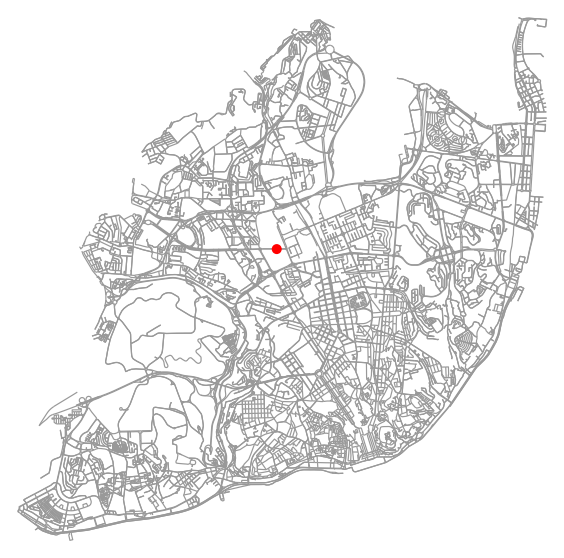

In [10]:
fig, ax = ox.plot.plot_graph(G_lx, node_color=nc, node_size=ns, edge_linewidth=1.2, figsize = (15,10), bgcolor = 'white')

If we check with google maps the node is exactly in front of the hospital building.

# Travel time analysis:

Now we are finally ready to do some analysis. In this section, for simplicity, let's ignore border effects and simply calculate how much time an ambulance, travelling from our node, with no traffic and at a speed of 50 km/h would take to reach the remaining nodes of the city.

In [11]:
G_lx = ox.project_graph(G_lx)
nodes_lx, edges_lx = ox.graph_to_gdfs(G_lx, nodes=True, edges=True)

/home/diogo_mota/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Let's define <code>trip_times</code>, which will be a list containing time values in minutes, in order to create an isochrone map. This way we can visualize which areas of the city are accessible from the hospital within a time threshold.

In [12]:
trip_times = [2, 5, 7, 10, 15]  # in minutes
travel_speed = 50  # walking speed in km/hour

In [13]:
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for _, _, _, data in G_lx.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

With our time values let's get 5 colors, one per time value.

In [14]:
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="inferno", start=0, return_hex=True)

First let's color all the nodes according to which ischrone area they correspond.

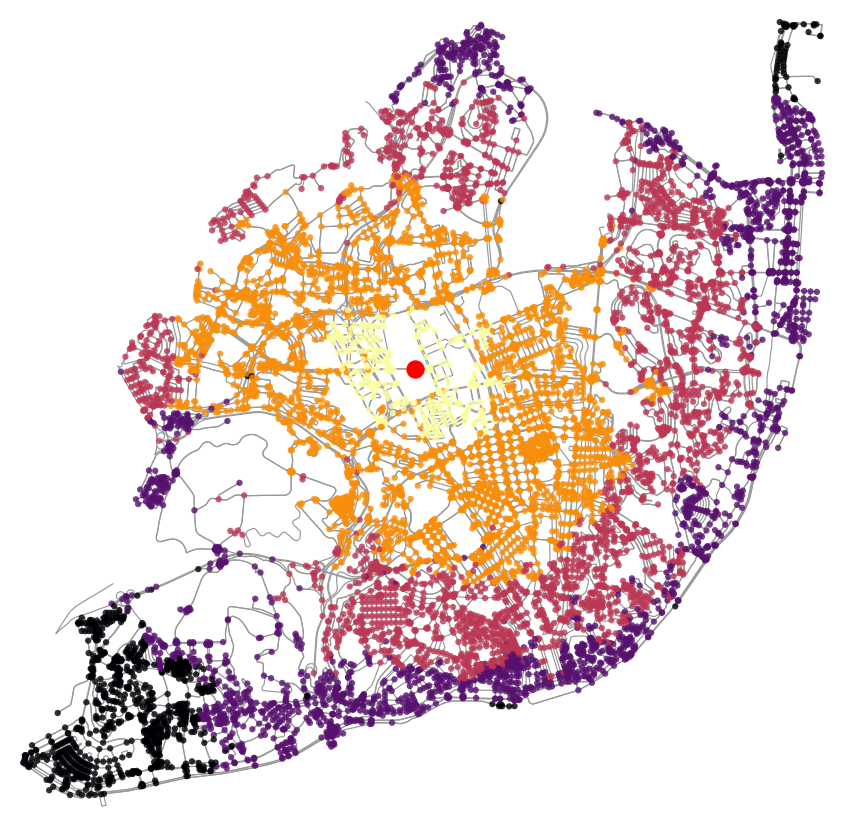

In [15]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
node_val=[]
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    #print(trip_time, color)
    subgraph = nx.ego_graph(G_lx, target, radius=trip_time, distance="time")
    for node in subgraph.nodes():
        node_colors[node] = color
        node_val.append(trip_time)
        
nc = [node_colors[node] if node in node_colors else "none" for node in G_lx.nodes()]
ns = [40 if node in node_colors else 0 for node in G_lx.nodes()]

cmap = mpl.colors.ListedColormap(iso_colors[::-1])
bounds = np.array(trip_times)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = ox.plot_graph(
    G_lx,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=1.2,
    edge_color="#999999",
    figsize = (25,15), bgcolor = 'white',
    show=False)

x = nodes_lx['x'].loc[3969026033]
y = nodes_lx['y'].loc[3969026033]

ax.scatter(x,y, s=300, c='red')

Finally let's create our isochrones and plot them.

/home/diogo_mota/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


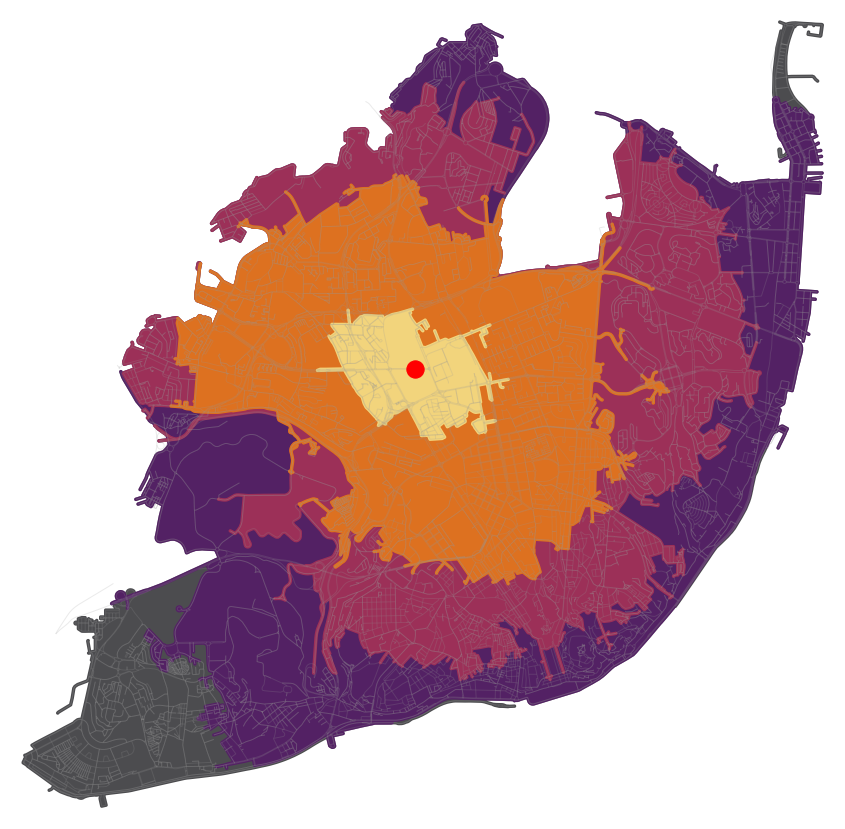

In [16]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, target, radius=trip_time, distance="time")

        node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({"id": list(subgraph.nodes)}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index("id")

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get("geometry", LineString([f, t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union

        # try to fill in surrounded areas so shapes will appear solid and
        # blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

isochrone_polys = make_iso_polys(G_lx, edge_buff=25, node_buff=0, infill=True)

fig, ax = ox.plot_graph(G_lx, show=False, close=False, edge_color="#999999", 
                        edge_alpha=0.2, node_size=0,
                        figsize = (25,15), bgcolor = 'white')

for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec="none", alpha=0.7, zorder=-1)
    ax.add_patch(patch)
    
x = nodes_lx['x'].loc[3969026033]
y = nodes_lx['y'].loc[3969026033]

ax.scatter(x,y, s=300, c='red')

Similarly, we can create these maps using more than one hospital. This of course depends on the type of analysis you want to do. If you want to define risk areas as areas where an ambulance would take longer than a threshold travelling from any hospital of Lisbon you can simply do this map considering more hospitals. If you want to analyse only one, then you can use what we have done.

At the end of this notebook I present an example of analysis using 2 hospitals!

# Symmetry Analysis:

In this section we analyse the symmetry of the shortest paths from the node of the hospital to the rest of the nodes of the network. With this we can see if going from the hospital to the given location will take longer or less than going from the location to the hospital.

This time, in order for the maps to be more accurate, we shouldn't ignore boundary effects. Therefore we will consider the surrounding districts of the city of Lisbon.

In [17]:
## Load data
city_name = 'Lisbon'

cities = ox.geocode_to_gdf(['Município de Lisboa', 'Município de Oeiras', 'Município da Amadora', 'Município de Loures', 'Município de Odivelas'])

whole_polygon = cities.unary_union #unary union of both geometries
city_pol = cities['geometry'].iloc[0] #geometry of just the city

G_1 = ox.graph_from_polygon(city_pol, network_type='drive', simplify=True) ## Lisbon's network
nodes_1, edges_1 = ox.graph_to_gdfs(G_1, nodes=True, edges=True)

G = ox.graph_from_polygon(whole_polygon, network_type='drive', simplify=True) ## whole network
#G_nx = nx.relabel.convert_node_labels_to_integers(G)

nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

weight = 'length'

/home/diogo_mota/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Even though we included the borders we only care about nodes from the city of Lisbon, so let's filter the nodes to use.

In [18]:
nodes_list = nodes['osmid'].tolist()
nodes_to_use = [node for node in list(G_1.nodes()) if node in nodes_list]

In [19]:
len(nodes_to_use)

9758

Our target remains the same, the Santa Maria Hospital.

In [20]:
nodes[nodes.osmid==3969026033]

y         x       osmid  ref highway  \
3969026033  38.750071 -9.160861  3969026033  NaN     NaN   

                             geometry  
3969026033  POINT (-9.16086 38.75007)

In [21]:
target = 3969026033

/home/diogo_mota/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Let's visualize where the hospital is in our new network.

In [22]:
nc = ['red' if node==target else 'blue' for node in nodes.osmid]
ns = [100 if node==target else 0 for node in nodes.osmid] 

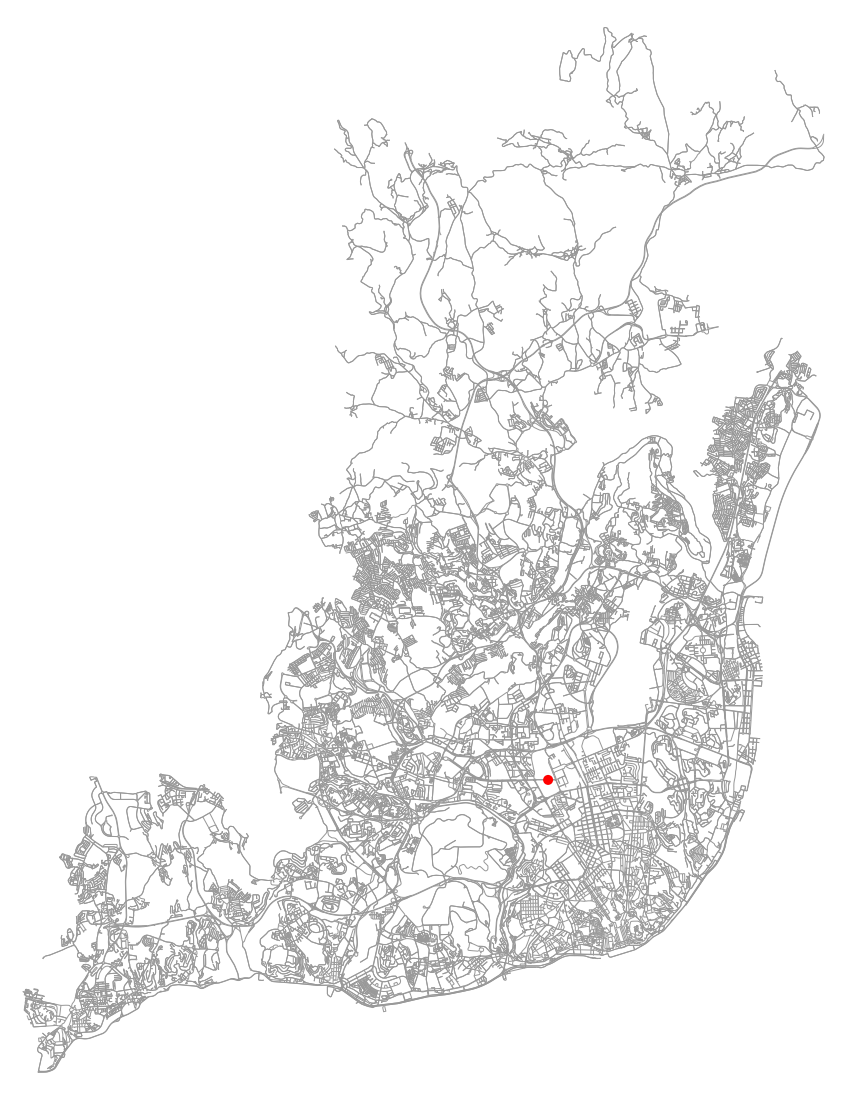

In [23]:
fig, ax = ox.plot.plot_graph(G, node_color=nc, node_size=ns, edge_linewidth=1, figsize = (30,20), bgcolor = 'white')

Now it's time to calculate the shortest paths.

In [24]:
def shortest_path(orig, targ):
    try:
        
        l_from = nx.shortest_path_length(G, targ, orig, weight=weight) ## from the hospital to the node
        l_to = nx.shortest_path_length(G, orig, targ, weight=weight) ## from the node to the hospital
        return orig, targ, l_from, l_to
    
    except Exception:
        # for unsolvable routes (due to directed graph perimeter effects)
        return orig, targ, -1, -1

/home/diogo_mota/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In order for us to be more efficeient let's paralellize our task and distribute the load of the calculation between our CPUs.

In [25]:
%%time
cpus=3 ## mudar numero de cores aqui
params = ((orig, targ) for orig, targ in product(nodes_to_use, [target]))
pool = mp.Pool(cpus)
sma = pool.starmap_async(shortest_path, params)
routes = sma.get()
pool.close()
pool.join()

CPU times: user 58.6 ms, sys: 72.1 ms, total: 131 ms
Wall time: 3min 31s


Now we simply extract the calculated lengths.

In [26]:
l_from = [val[2] for val in routes]
l_to = [val[3] for val in routes]

df = pd.DataFrame(zip(l_from, l_to), columns = ['L from', 'L to'])
df

L from      L to
0     2915.760  2459.664
1     2540.465  2834.959
2     4049.241  3550.841
3     2894.077  2622.481
4     2910.985  2639.389
...        ...       ...
9753  8049.406  8053.888
9754  7945.903  7950.385
9755  7969.234  7973.716
9756  6102.693  5205.572
9757  1801.424  1578.435

[9758 rows x 2 columns]

We define a measure of symmetry: R, which is equal to divinding L_from by L_to.

In [27]:
R_list =[]

for Lfrom, Lto in zip(l_from, l_to):
    
    if Lfrom==-1 and Lto==-1:
        R_list.append(-1)
    elif Lfrom==0 and Lto==0:
        R_list.append(0)
    else:
        R_list.append(Lto/Lfrom)

/home/diogo_mota/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
df['R'] = R_list
df['Origin'] = nodes_to_use
df

L from      L to         R      Origin
0     2915.760  2459.664  0.843576    21270959
1     2540.465  2834.959  1.115921    21270962
2     4049.241  3550.841  0.876915    21270969
3     2894.077  2622.481  0.906155    21272087
4     2910.985  2639.389  0.906700    21272088
...        ...       ...       ...         ...
9753  8049.406  8053.888  1.000557  7998288917
9754  7945.903  7950.385  1.000564  7998288944
9755  7969.234  7973.716  1.000562  7998288945
9756  6102.693  5205.572  0.852996  8001694332
9757  1801.424  1578.435  0.876215  8032231060

[9758 rows x 4 columns]

In [29]:
R_list = list(df.R)

/home/diogo_mota/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Next, in order for our measure to be more sensitive to variations let's calculate the logarithm of R. WIth this our maps will show a more diverse set of values of r.

In [30]:
r_list=[]
for val in R_list:
    
    if val==0 or val==-1:
        r_list.append(-1)
    else:
        r_list.append(np.log(val))

It's finally time to visualize our results. We need to choose the maximum and minimum thresholds for the values of r (Not R!).

In [31]:
upper = 0.1
lower = -0.1

Now just choose a set of colors to use.

In [32]:
cmap = mpl.colors.ListedColormap(['#d73027','#f46d43','#fdae61','#fee090','#e0f3f8','#abd9e9','#74add1','#4575b4'])
#bounds = np.array([0.9, 0.925, 0.95, 0.975, 1.0, 1.025, 1.05, 1.075, 1.10])
bounds = np.linspace(lower,upper,9)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

We need to assign a color for a given node according to it's value of r.

In [33]:
nk = []
for t in r_list:

    if t<upper and t !=0 and t>lower:
        nk.append(t)


Now we make any value that is bigger than our upper bound and lower than our lower bound have the color of the maximum and minimum bound respectively.

In [34]:
valor_min = min(nk)
valor_max = max(nk)

In [35]:
nc=[]
for b in r_list:
        
    if b<upper and b>lower:
        
        nc.append(mapper.to_rgba(b))
    
    elif b<=lower:
        nc.append(mapper.to_rgba(valor_min))
    
    elif b>upper:
        nc.append(mapper.to_rgba(valor_max))
        
len(nc)

9758

Finally we don't want to see nodes where the shortest path doesn't exist.

In [36]:
ns = []

for v in R_list:
    if v != -1:
        ns.append(60)

    else:
        ns.append(0)
len(ns)

9758

In [37]:
## Get the coordinates of the hospital because we want to plot it's location above the network (it's amatter of visibility)
x = nodes_1['x'].loc[3969026033]
y = nodes_1['y'].loc[3969026033]

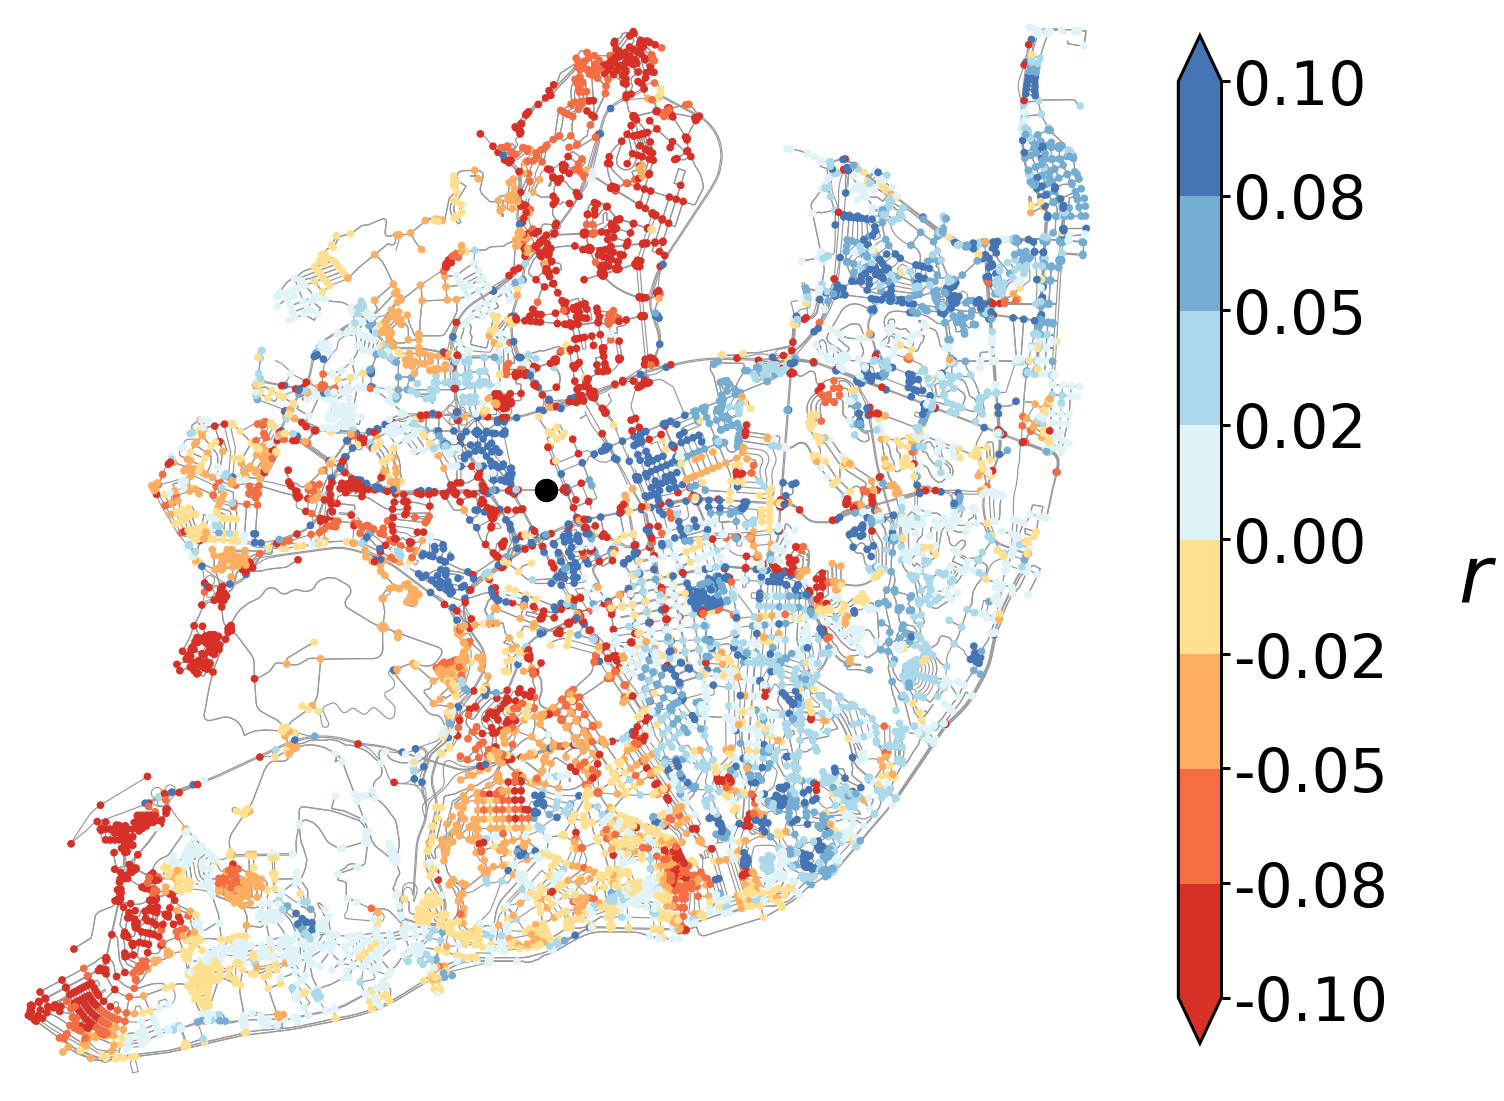

In [38]:
fg_color = 'black'

fig, ax = ox.plot.plot_graph(G_1, node_color=nc, node_size=ns, edge_linewidth=1.2, figsize = (30,20), show=False, bgcolor = 'white')
kwargs = {'format': '%.2f'}
ax.scatter(x,y, s=500, c='black')
## Create a colobar 
position=fig.add_axes([0.80,0.16,0.02,0.70]) 
cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, cax=position, extend='both', orientation='vertical', aspect=50, shrink=0.4, pad=0.0000001, **kwargs)
cb.set_label('$r$', fontsize = 80, color = fg_color, rotation = 'horizontal', labelpad=90)
cb.ax.tick_params(labelsize=60, color = fg_color, length=8, width=3)
# set colorbar tick color
cb.ax.yaxis.set_tick_params(color=fg_color)
cb.cmap.set_over(mapper.to_rgba(valor_max))
cb.cmap.set_under(mapper.to_rgba(valor_min))
# set colorbar edgecolor 
cb.outline.set_edgecolor(fg_color)
cb.outline.set_linewidth(3)


# set colorbar ticklabels
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color=fg_color)
fig.set_frameon(True)

We can also see our results in a regualar plot.

/home/diogo_mota/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


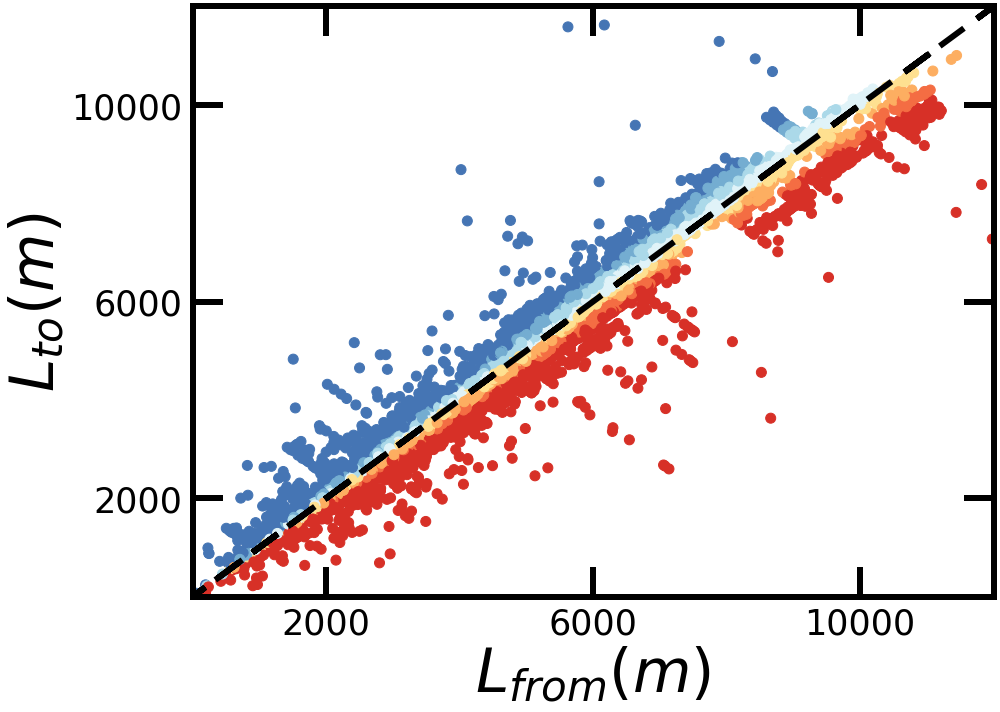

In [39]:
##x = list(data['L from length'])
##y = list(data['L to length'])

fig, axs = plt.subplots(1,1, figsize=(14,10))
s = 100

axs.scatter(l_from, l_to, c = nc, s=100, zorder=-5)
axs.plot(l_from, l_from, linestyle = 'dashed', linewidth=6, color = 'black', dashes = (5, 10), zorder=-5)
axs.set_xlim(0, 12000)
axs.set_ylim(0, 12000)

axs.set_xticks([2000, 6000, 10000])
axs.set_yticks([2000, 6000, 10000])


for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(6)
    
#axs.grid(True)
axs.set_xlabel('$L_{from}(m)$', fontsize=60)
axs.xaxis.set_ticks_position('both')
axs.set_ylabel('$L_{to}(m)$', fontsize=60)
axs.yaxis.set_ticks_position('both')
axs.tick_params(which='both', length=30, width=6, direction="in", pad=10)


axs.tick_params(labelsize=35)

plt.tight_layout()


This plot helps us visualize how assymetrical the journeys are with the help of our guide line that indicates an r of 0 (i.e, R=1).

There are plenty of analysis you can now perform with the data we produced. For instance you can analyse the fluctuations of r and investigate what causes them. 

# Two Hospitals example:

In this last section we do a similar analysis to the one performed in the first section, however this time we don't create isochrones and we use 2 hospitals.

In [58]:
cities = ox.geocode_to_gdf(['Município de Lisboa'])['geometry'].iloc[0]

G2 = ox.graph_from_polygon(cities, network_type='drive', simplify=True)
nodes2, edges2 = ox.graph_to_gdfs(G2, nodes=True, edges=True)

In [59]:
hospital1 = target

New Hospital:

In [60]:
target2 = (38.7287248, -9.1391148) ## Hospital Dona Estefania
hospital2 = ox.get_nearest_node(G2, target2)
hospital2

580281448

Since we have two hospitals, for each node we comapre the length of the journey between the hospitals and the nodes and assign the smallest length. Afterwards we define ourambulance's speed and transform our length values to time value (in minutes).

In [61]:
def shortest_path_hospitals(node, hospital1, hospital2):
    
    try:
        route_length_1 = nx.shortest_path_length(G2, hospital1, node, weight='length')
        route_length_2 = nx.shortest_path_length(G2, hospital2, node, weight='length')
        if route_length_1 < route_length_2:

            return route_length_1
        elif route_length_1 > route_length_2:
 
            return route_length_2

    except nx.exception.NetworkXNoPath:
        return -1 

In [62]:
nodes_lx = nodes2['osmid'].tolist()

In [63]:
%%time
cpus=3 ## mudar numero de cores aqui
params = ((orig, hosp1, hosp2) for orig, hosp1, hosp2 in product(nodes_lx, [hospital1], [hospital2]))
pool = mp.Pool(cpus)
sma = pool.starmap_async(shortest_path_hospitals, params)
routes = sma.get()
pool.close()
pool.join()

CPU times: user 35.9 ms, sys: 84.1 ms, total: 120 ms
Wall time: 3min 29s


In [64]:
len(routes)

9758

In [65]:
travel_speed = 50  # km/h
meters_per_minute = travel_speed * 1000 / 60

In [66]:
time_values = [val/meters_per_minute for val in routes]
time_values[:3]

[3.4989119999999994, 3.0485579999999994, 4.859089199999999]

In [67]:
upper = 10 ## minutes
lower = 2 ## minutes

In [68]:
cmap = mpl.colors.ListedColormap(['#d73027','#f46d43','#fdae61','#fee090','#e0f3f8','#abd9e9','#74add1','#4575b4'])
#bounds = np.array([0.9, 0.925, 0.95, 0.975, 1.0, 1.025, 1.05, 1.075, 1.10])
bounds = np.linspace(lower,upper,9)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

In [69]:
nk = []
for t in time_values:

    if t<upper and t !=0 and t>lower:
        nk.append(t)


In [70]:
valor_min = min(nk)
valor_max = max(nk)

In [71]:
nc=[]
for b in time_values:
        
    if b<upper and b>lower:
        
        nc.append(mapper.to_rgba(b))
    
    elif b<=lower:
        nc.append(mapper.to_rgba(valor_min))
    
    elif b>upper:
        nc.append(mapper.to_rgba(valor_max))
        
len(nc)

9758

In [72]:
ns = []

for v in time_values:
    if v != -1:
        ns.append(60)

    else:
        ns.append(0)
len(ns)

9758

In [73]:
## Get the coordinates of the hospital because we want to plot it's location above the network (it's amatter of visibility)
x1 = nodes2['x'].loc[3969026033]
y1 = nodes2['y'].loc[3969026033]

x2 = nodes2['x'].loc[580281448]
y2 = nodes2['y'].loc[580281448]

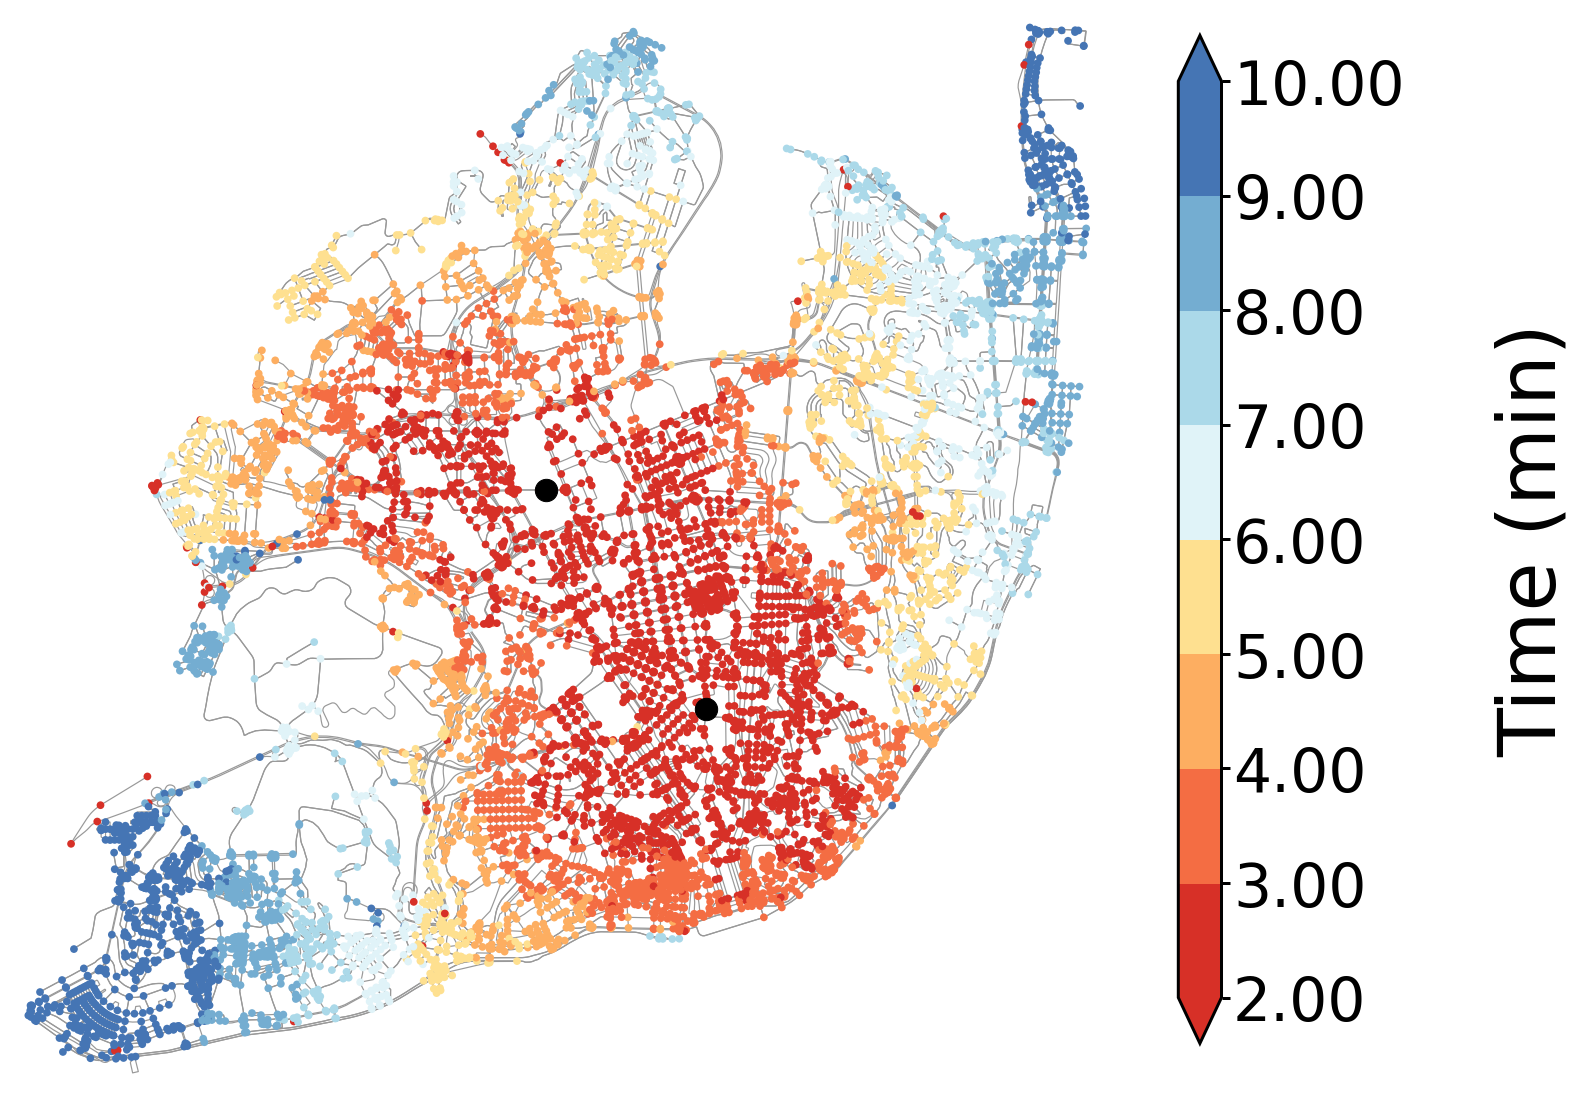

In [74]:
fg_color = 'black'

fig, ax = ox.plot.plot_graph(G2, node_color=nc, node_size=ns, edge_linewidth=1.2, figsize = (30,20), show=False, bgcolor = 'white')
kwargs = {'format': '%.2f'}
ax.scatter(x1,y1, s=500, c='black')
ax.scatter(x2,y2, s=500, c='black')
## Create a colobar 
position=fig.add_axes([0.80,0.16,0.02,0.70]) 
cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, cax=position, extend='both', orientation='vertical', aspect=50, shrink=0.4, pad=0.0000001, **kwargs)
cb.set_label('Time (min)', fontsize = 80, color = fg_color, rotation = 'vertical', labelpad=90)
cb.ax.tick_params(labelsize=60, color = fg_color, length=8, width=3)
# set colorbar tick color
cb.ax.yaxis.set_tick_params(color=fg_color)
cb.cmap.set_over(mapper.to_rgba(valor_max))
cb.cmap.set_under(mapper.to_rgba(valor_min))
# set colorbar edgecolor 
cb.outline.set_edgecolor(fg_color)
cb.outline.set_linewidth(3)


# set colorbar ticklabels
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color=fg_color)
fig.set_frameon(True)